In [13]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    AddChanneld,
    Compose,
    LoadImaged,
    RandAffined,
    Resized,
    ScaleIntensityd,
    ToTensord,
    SqueezeDimd,
    Spacingd,
    EnsureTyped,
)

from torch.utils.data import Dataset
import monai
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR
from transforms import MaskIntensityMultid

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
)

import sys

import torch
torch.multiprocessing.set_sharing_strategy('file_system')
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import StochasticWeightAveraging
import pytorch_lightning as pl
from monai.metrics import compute_meandice, DiceMetric

import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import torch
from torch.nn import MSELoss
from monai.apps import download_url, download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import BendingEnergyLoss, MultiScaleLoss, DiceLoss, LocalNormalizedCrossCorrelationLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
from monai.transforms import (
    Compose,
    LoadImaged,
    RandAffined,
    Resized,
    ScaleIntensityd,
    apply_transform
)
from monai.utils import set_determinism, first
from glob import glob
import itertools
from pytorch_lightning.loggers import TensorBoardLogger
from typing import Optional, Sequence, Union, Callable

set_determinism(seed=0)

from monai.data.utils import pickle_hashing

In [14]:
class CustomCacheDataset(CacheDataset):
    def __init__(
        self,
        data: Sequence,
        transform: Optional[Union[Sequence[Callable], Callable]] = None,
    ) -> None:
        if not isinstance(transform, Compose):
            transform = Compose(transform)
        super().__init__(data=data, 
                         transform=transform
                        )        
    
    def __getitem__(self, index: int):    
        index_moving = torch.randint(self.__len__(),(1,))
        index_fixed = torch.randint(self.__len__(),(1,))
        
        while(index_fixed == index_moving):
            index_fixed = torch.randint(self.__len__(),(1,))
        
        _moving = self._transform(index_moving)
        _fixed = self._transform(index_fixed)
        
        moving_fixed = {
                "moving_image": _fixed['mri'],
                "moving_label": _fixed['label'],            
                "fixed_image": _moving['mri'],  
                "fixed_label": _moving['label'],
        }

        return moving_fixed  
    

In [18]:
device = torch.device("cuda:0")

class Net(pl.LightningModule):
    def __init__(self, lr):
        super().__init__()
        
        self.lr = lr
        
        self._model = monai.networks.nets.GlobalNet(
           image_size=(128, 128, 128),
           spatial_dims=3,
           in_channels=2,
           num_channel_initial=16,
           depth=5).to(device)
        
        self._warp = Warp("bilinear", "border").to(device)
        
        self.img_loss = LocalNormalizedCrossCorrelationLoss()#smooth_nr=1e-05, smooth_dr=1e-03)
        #self.img2_loss = MSELoss()
        self.lbl_loss = DiceLoss()
        self.lbl_loss = MultiScaleLoss(self.lbl_loss, scales=[0, 1, 2, 4, 8, 16])
        self.ddf_loss = BendingEnergyLoss()

        self.max_epochs = 1000
        
        self.best_train_loss = np.inf 
        self.best_train_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # prepare data
        
        data_dir = os.path.join("datasets2", "IRIS")
        mris = sorted(glob(os.path.join(data_dir, 'MRI', "*.nii.gz")))
        labels = sorted(glob(os.path.join(data_dir, 'Mask', "*.nii.gz")))
        
        mri_number = 300
        train_mris = mris[:mri_number]
        train_labels = labels[:mri_number]

        train_files = [
            {
                "mri": train_mris[i],   
                "label": train_labels[i],
            }    
            for i in range(len(train_mris))
        ]           
        
        train_transforms = Compose(
            [
                LoadImaged(
                    ensure_channel_first=True,
                    keys=["mri", "label"]
                ),             
                ScaleIntensityd(
                    keys=["mri"],
                    minv=0.0, maxv=1.0,
                ),
                MaskIntensityMultid(
                    keys=["mri"],
                    mask_key=("label"),
                ),
                RandAffined(           
                    keys=["mri", "label"],
                    mode=('bilinear', 'nearest'),
                    prob=1.0,
                    rotate_range=(0, 0, np.pi / 15),             
                    scale_range=(0.1, 0.1, 0.1),
                ),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(
                    keys=["mri", "label"]
                ),    
                MaskIntensityMultid(
                    keys=["mri"],
                    mask_key=("label"),
                ),
                ScaleIntensityd(
                    keys=["mri"],
                    minv=0.0, maxv=1.0,
                ), 
            ]
        )
        self.train_ds = CustomCacheDataset(data=train_files, transform=train_transforms)
        #self.val_ds = CustomCacheDataset(data=train_files, transform=val_transforms)


    def train_dataloader(self):        
        train_loader = DataLoader(self.train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
        return train_loader

    def configure_optimizers(self):   
        optimizer = torch.optim.Adam(self._model.parameters(), self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        moving_image = batch["moving_image"].to(device)
        moving_label = batch["moving_label"].to(device)
        fixed_image = batch["fixed_image"].to(device)
        fixed_label = batch["fixed_label"].to(device)
                
        ddf = self.forward(torch.cat((moving_image, fixed_image), dim=1))
        
        pred_image = self._warp(moving_image, ddf)
        pred_label = self._warp(moving_label, ddf)
        
        img_loss = 1 * self.img_loss(pred_image, fixed_image)       
        lbl_loss = 1  * self.lbl_loss(pred_label, fixed_label)
        ddf_loss = 1  * self.ddf_loss(ddf)
        #ddf_loss = 1 * self.img2_loss(pred_image, fixed_image)  
        loss = img_loss + lbl_loss + ddf_loss        
        
        metric = compute_meandice(y_pred=pred_label, y=fixed_label)
        
        return {"loss": loss, "metric": metric, "img_loss": img_loss, "lbl_loss": lbl_loss, "ddf_loss": ddf_loss}
    
    def training_epoch_end(self, outputs):                  
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_metric = torch.stack([x["metric"] for x in outputs]).mean()
        avg_img_loss = torch.stack([x["img_loss"] for x in outputs]).mean()
        avg_lbl_loss = torch.stack([x["lbl_loss"] for x in outputs]).mean()
        avg_ddf_loss = torch.stack([x["ddf_loss"] for x in outputs]).mean()
        print(
            f"epoch: {self.current_epoch}"
        )
        print(
            "{}: loss: {:.4f} - dice: {:.4f} -- lncc: {:.4f}, lbl: {:.4f}, ddf: {:.4f}".format(
                        "train", avg_loss, avg_metric, avg_img_loss, avg_lbl_loss, avg_ddf_loss,
                    )
        )
        
    #def validation_step(self, batch, batch_idx):        
    #    return None
    
    #def validation_epoch_end(self, outputs):
    #    return None

In [19]:
net = Net(lr=1e-3)
root_dir = os.path.abspath(os.getcwd())
checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="test_model-3")
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=net.max_epochs,
    callbacks=checkpoint_callback,
    default_root_dir=root_dir,
    auto_lr_find=True,
    precision=16,   
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Loading dataset:  30%|█████████████████████████████████▌                                                                              | 90/300 [00:08<00:20, 10.02it/s]


Loading dataset:  61%|████████████████████████████████████████████████████████████████████                                           | 184/300 [00:16<00:10, 11.29it/s]


Loading dataset:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 277/300 [00:25<00:02,  8.46it/s]


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.


epoch: 0
train: loss: -0.5916 - dice: 0.7271 -- lncc: -0.9673, lbl: 0.3758, ddf: 0.0000


Restoring states from the checkpoint path at /home/valentini/dev/Mousenet/.lr_find_22151648-04d7-4fb2-838c-da88b59ead44.ckpt


1.2589254117941673e-09


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


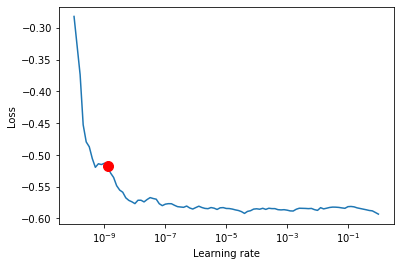

In [20]:
lr_finder = trainer.tuner.lr_find(net,
                                 min_lr=1e-10,
                                 max_lr=1,
                                 early_stop_threshold=None,
                                 num_training=100,
                                 mode='exponential'
                                 )
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
net.hparams.lr = new_lr
net.lr = new_lr
print(new_lr)

In [ ]:
trainer.fit(net)

In [ ]:
numslice = 64
#net.load_from_checkpoint(os.path.join(root_dir, "best_metric_model-v1.ckpt"))
#net.prepare_data()
net.eval()
net.to(device)
   
with torch.no_grad():
    
    moving_name = os.path.split(
        net.train_ds[0]["moving_image"].meta["filename_or_obj"]
    )[1]
    print(moving_name)
    moving = net.train_ds[0]["moving_image"]
    moving_image = torch.unsqueeze(moving, 1).cuda()  
    movinglbl = net.train_ds[0]["moving_label"]
    moving_label = torch.unsqueeze(movinglbl, 1).cuda()  
    
    for i in range(len(net.train_ds)):    
        fixed_name =  os.path.split(
            net.train_ds[i]["fixed_image"].meta["filename_or_obj"]
        )[1]  
        if moving_name != fixed_name:
            print(fixed_name)  
            fixed = net.train_ds[i]["fixed_image"]        
            fixed_image = torch.unsqueeze(fixed, 1).cuda()    
            fixedlbl = net.train_ds[i]["fixed_label"]        
            fixed_label = torch.unsqueeze(fixedlbl, 1).cuda()    
            ddf = net.forward(torch.cat((moving_image, fixed_image), dim=1))    
            pred_image = net._warp(moving_image, ddf)  
            pred_label = net._warp(moving_label, ddf) 
            
            dice = compute_meandice(y_pred=pred_label, y=fixed_label)
            print(dice.item())

            plt.figure("check", (18, 6))        
            plt.subplot(1, 6, 1)
            plt.title(f"moving_image")
            plt.imshow(moving_image.cpu().numpy()[0, 0, :, :, numslice])
            plt.subplot(1, 6, 2)
            plt.title(f"moving_label")
            plt.imshow(moving_label.cpu().numpy()[0, 0, :, :, numslice])
            plt.subplot(1, 6, 3)
            plt.title(f"fixed_image")
            plt.imshow(fixed_image.cpu().numpy()[0, 0, :, :, numslice])
            plt.subplot(1, 6, 4)
            plt.title(f"fixed_label")
            plt.imshow(fixed_label.cpu().numpy()[0, 0, :, :, numslice])
            plt.subplot(1, 6, 5)
            plt.title(f"pred_image")
            plt.imshow(pred_image.cpu().numpy()[0, 0, :, :, numslice])
            plt.subplot(1, 6, 6)
            plt.title(f"pred_label")
            plt.imshow(pred_label.cpu().numpy()[0, 0, :, :, numslice])
            plt.show()


In [ ]:
print(np.min(moving_image))
print(np.max(moving_image))
print('-'*10)
print(np.min(fixed_image))
print(np.max(fixed_image))
print('-'*10)
print(np.min(pred_image))
print(np.max(pred_image))
print('-'*10)